# Facial Keypoint Detection Improvement

### By Tingwen & Sanjay Dorairaj
### W207-5 Spring 2017

This notebook contains the steps taken towards making additional improvements to the Facial Keypoint Detection Kaggle Challenge.

For the baseline section, we had started from a 2 layer simple neural network and tested some of the additional features from the python blog. The baseline we set was a val_loss of 0.00111 which translate to RMSE of 1.59920. And the baseline model contains 3 convolutions,pooling layers, and dropout layers and 2 fully connected layer with data augmentation and changed learning rate.

In this notebook, we are going to start from this baseline and try to improve the model in various ways. 

Note that several concepts used in this exercise are adapted from Daniel Nouri's blog post at http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/

## System Configuration

### GPU Configuration
1. GeForce GTX TITAN X
2. AWS - GRID K520 g2.2xlarge 

### Software Configuration
1. Lasagne/Theano
2. Ubuntu 14.04/16.04

## Reference Material

1. GitHub repository - https://github.com/tingwenbao/Facial_KeyPoints_Detection.git. Includes two top-level folders - Baseline and Improvements and captures the baseline version and the improvements respectivel.
2. Kaggle link - https://www.kaggle.com/c/facial-keypoints-detection
3. Reference Tutorial - http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/
4. Setting up a VM for this project on AWS- http://markus.com/install-theano-on-aws/#comment-3206748383

## 1. Load Data, Libraries, and Functions

In [22]:
## import libraries

import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
import sys
import matplotlib.pyplot as pyplot
import cPickle as pickle
from nolearn.lasagne import BatchIterator
import lasagne
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet
from lasagne.updates import adam

# set recursion limit due to handle updates to pickle files for the large network models
sys.setrecursionlimit(100000)


## 2. Loading the training and test data set

This section includes two methods - load and load2d, that load the train and test data.

The load method has the parameters
* test - boolean value indicating whether to load the training data or the test data
* cols - used when specific columns need to be loaded
* fillNA - boolean value indicates whether NA cells must be filled with the corresponding value from the previous row.

The load2d method uses the load method to load the data but reshapes the data as a 2d array

In [23]:
#change the directory to where you put the datasets

FTRAIN = '~/Facial_KeyPoints_Detection/training.csv'
FTEST = '~/Facial_KeyPoints_Detection/test.csv'

def load(test=False, cols=None, fillNA=False):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Pass a list of *cols* if you're only interested in a subset of the
    target columns.
    """
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    print(df.count())  # prints the number of values for each column
    
    if  fillNA:
        df = df.fillna(method='ffill')
    else:
        df = df.dropna()  # drop all rows that have missing values in them
        
    print(df.count())  # prints the number of values for each column
    
    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None
        
    return X, y

def load2d(test=False, cols=None):
    X, y = load(test=test, cols=cols)
    X = X.reshape(-1, 1, 96, 96)
    return X, y

## 3. Utility Functions

In this section several utility functions that help with the project are defined. 

### float32

This function typecasts a numpy array as a float32. It is primarily used to to ensure that there are no type incompatibilities.

### AdjustVariable

This method is used as a callback that allows for a cleaner way to update parameters used by the Neural Network for each epoch. 

AdjustVariable has the following parameters
* NeuralNet parameter ame
* start value
* stop value

#### Example:

Below is an example of usage where the parameter in each epoch for update_learning_rate and update_momentum is a linearly increasing value between the start and stop values. 

        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001)
        AdjustVariable('update_momentum', start=0.9, stop=0.999)
        
### FlipBatchIterator

This method flips half the images in a batch allowing the neural net to generalize better. The input is the mini-batch size.

### EarlyStopping

This method enforces an early stopping criteria to allow the Neural Network to stop when a specific early stopping criteria is met. 

Early Stopping has the following parameters
* patience - if the validation loss is more than that observed earlier then we re-initialize the net with the prior best value and stop training. the patience parameter tells how far back to look to see if a better validation result was observed.

In [24]:
def float32(k):
    return np.cast['float32'](k)

class AdjustVariable(object):
    def __init__(self, name, start=0.03, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)

        epoch = train_history[-1]['epoch']
        new_value = float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)
        
class FlipBatchIterator(BatchIterator):
    flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
        ]

    def transform(self, Xb, yb):
        Xb, yb = super(FlipBatchIterator, self).transform(Xb, yb)

        # Flip half of the images in this batch at random:
        bs = Xb.shape[0]
        indices = np.random.choice(bs, bs / 2, replace=False)
        Xb[indices] = Xb[indices, :, :, ::-1]

        if yb is not None:
            # Horizontal flip of all x coordinates:
            yb[indices, ::2] = yb[indices, ::2] * -1

            # Swap places, e.g. left_eye_center_x -> right_eye_center_x
            for a, b in self.flip_indices:
                yb[indices, a], yb[indices, b] = (
                    yb[indices, b], yb[indices, a])

        return Xb, yb
    
## Define early stop method to reduce training time
class EarlyStopping(object):
    def __init__(self, patience=100):
        self.patience = patience
        self.best_valid = np.inf
        self.best_valid_epoch = 0
        self.best_weights = None

    def __call__(self, nn, train_history):
        current_valid = train_history[-1]['valid_loss']
        current_epoch = train_history[-1]['epoch']
        if current_valid < self.best_valid:
            self.best_valid = current_valid
            self.best_valid_epoch = current_epoch
            self.best_weights = nn.get_all_params_values()
        elif self.best_valid_epoch + self.patience < current_epoch:
            print("Early stopping.")
            print("Best valid loss was {:.6f} at epoch {}.".format(
                self.best_valid, self.best_valid_epoch))
            nn.load_params_from(self.best_weights)
            raise StopIteration()
    


## 4.  Revisiting Baseline Model Performance

In [5]:
import theano

net6 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),  
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),  
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('dropout3', layers.DropoutLayer),  
        ('hidden4', layers.DenseLayer),
        ('dropout4', layers.DropoutLayer),  
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    dropout1_p=0.1,  
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    dropout2_p=0.2,  
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    dropout3_p=0.3,  
    hidden4_num_units=500,
    dropout4_p=0.5,  
    hidden5_num_units=500,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    regression=True,
    batch_iterator_train=FlipBatchIterator(batch_size=128),
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        ],
    max_epochs=3000,
    verbose=1,
    )

sys.setrecursionlimit(10000)

X, y = load2d()
net6.fit(X, y)

with open('net6.pickle', 'wb') as f:
    pickle.dump(net6, f, -1)


left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

     89     0.00441     0.00417    1.05725  0.83s
     90     0.00441     0.00417    1.05728  0.85s
     91     0.00440     0.00415    1.05791  0.83s
     92     0.00440     0.00416    1.05973  0.83s
     93     0.00439     0.00416    1.05751  0.83s
     94     0.00438     0.00415    1.05626  0.83s
     95     0.00440     0.00414    1.06189  0.83s
     96     0.00438     0.00413    1.05969  0.83s
     97     0.00437     0.00413    1.05828  0.83s
     98     0.00438     0.00413    1.06110  0.84s
     99     0.00438     0.00413    1.06131  0.85s
    100     0.00436     0.00412    1.05743  0.86s
    101     0.00436     0.00412    1.05774  0.87s
    102     0.00435     0.00412    1.05688  0.87s
    103     0.00438     0.00412    1.06390  0.88s
    104     0.00435     0.00411    1.05803  0.88s
    105     0.00436     0.00411    1.06103  0.87s
    106     0.00435     0.00411    1.05823  0.88s
    107     0.00434     0.00411    1.05735  0.88s
    108     0.00435     0.00410    1.06209  0.88s


    219     0.00388     0.00362    1.07065  0.90s
    220     0.00385     0.00361    1.06683  0.90s
    221     0.00385     0.00361    1.06686  0.90s
    222     0.00386     0.00360    1.07309  0.90s
    223     0.00383     0.00359    1.06600  0.90s
    224     0.00385     0.00358    1.07523  0.90s
    225     0.00384     0.00358    1.07369  0.90s
    226     0.00383     0.00357    1.07222  0.90s
    227     0.00383     0.00357    1.07311  0.90s
    228     0.00384     0.00356    1.07836  0.90s
    229     0.00381     0.00356    1.07278  0.89s
    230     0.00380     0.00354    1.07320  0.91s
    231     0.00381     0.00354    1.07676  0.89s
    232     0.00379     0.00354    1.07163  0.90s
    233     0.00378     0.00353    1.07026  0.90s
    234     0.00379     0.00352    1.07654  0.91s
    235     0.00378     0.00351    1.07766  0.90s
    236     0.00378     0.00351    1.07811  0.90s
    237     0.00378     0.00350    1.07939  0.90s
    238     0.00376     0.00350    1.07489  0.90s


    350     0.00306     0.00273    1.12302  0.91s
    351     0.00307     0.00273    1.12605  0.91s
    352     0.00305     0.00271    1.12325  0.91s
    353     0.00306     0.00271    1.12852  0.91s
    354     0.00304     0.00272    1.11970  0.91s
    355     0.00305     0.00271    1.12711  0.91s
    356     0.00302     0.00271    1.11569  0.91s
    357     0.00306     0.00268    1.13953  0.91s
    358     0.00300     0.00270    1.11426  0.93s
    359     0.00300     0.00268    1.11921  0.93s
    360     0.00301     0.00268    1.12315  0.91s
    361     0.00302     0.00268    1.12836  0.91s
    362     0.00301     0.00268    1.12463  0.91s
    363     0.00300     0.00266    1.12420  0.91s
    364     0.00298     0.00266    1.11981  0.92s
    365     0.00300     0.00266    1.12769  0.91s
    366     0.00299     0.00266    1.12694  0.91s
    367     0.00299     0.00264    1.12931  0.91s
    368     0.00297     0.00264    1.12619  0.91s
    369     0.00298     0.00263    1.13258  0.92s


    492     0.00258     0.00225    1.14759  0.91s
    493     0.00257     0.00225    1.14266  0.91s
    494     0.00255     0.00224    1.13904  0.91s
    495     0.00257     0.00224    1.14918  0.91s
    496     0.00256     0.00223    1.14432  0.92s
    497     0.00255     0.00223    1.14006  0.92s
    498     0.00255     0.00223    1.14358  0.91s
    499     0.00254     0.00223    1.13765  0.91s
    500     0.00254     0.00223    1.14044  0.91s
    501     0.00254     0.00223    1.14102  0.91s
    502     0.00252     0.00222    1.13497  0.91s
    503     0.00255     0.00222    1.14763  0.91s
    504     0.00253     0.00222    1.14075  0.91s
    505     0.00256     0.00223    1.15129  0.91s
    506     0.00255     0.00223    1.14369  0.91s
    507     0.00256     0.00222    1.15219  0.91s
    508     0.00254     0.00221    1.14747  0.91s
    509     0.00254     0.00221    1.14894  0.92s
    510     0.00253     0.00221    1.14225  0.91s
    511     0.00253     0.00221    1.14546  0.91s


    639     0.00229     0.00200    1.14220  0.91s
    640     0.00231     0.00200    1.15713  0.91s
    641     0.00229     0.00200    1.14443  0.92s
    642     0.00230     0.00200    1.14862  0.93s
    643     0.00230     0.00200    1.15054  0.91s
    644     0.00229     0.00199    1.14732  0.91s
    645     0.00229     0.00199    1.15070  0.91s
    646     0.00229     0.00199    1.15043  0.91s
    647     0.00228     0.00199    1.14447  0.91s
    648     0.00228     0.00200    1.14014  0.91s
    649     0.00228     0.00199    1.14653  0.91s
    650     0.00230     0.00198    1.15991  0.91s
    651     0.00227     0.00199    1.13975  0.92s
    652     0.00227     0.00199    1.14247  0.91s
    653     0.00229     0.00199    1.14747  0.91s
    654     0.00226     0.00198    1.13906  0.91s
    655     0.00227     0.00198    1.14680  0.91s
    656     0.00228     0.00198    1.15041  0.91s
    657     0.00228     0.00197    1.15553  0.91s
    658     0.00226     0.00198    1.14033  0.91s


    789     0.00210     0.00183    1.14704  0.91s
    790     0.00212     0.00182    1.16272  0.91s
    791     0.00210     0.00183    1.14900  0.91s
    792     0.00213     0.00183    1.16365  0.91s
    793     0.00212     0.00183    1.15430  0.91s
    794     0.00212     0.00183    1.15693  0.92s
    795     0.00211     0.00183    1.15487  0.91s
    796     0.00210     0.00183    1.15193  0.92s
    797     0.00210     0.00182    1.15158  0.91s
    798     0.00211     0.00182    1.15944  0.91s
    799     0.00207     0.00182    1.13953  0.91s
    800     0.00209     0.00182    1.14479  0.93s
    801     0.00212     0.00182    1.16139  0.91s
    802     0.00209     0.00182    1.14670  0.92s
    803     0.00211     0.00181    1.16591  0.91s
    804     0.00210     0.00182    1.15674  0.91s
    805     0.00208     0.00182    1.14358  0.91s
    806     0.00209     0.00181    1.15827  0.91s
    807     0.00211     0.00181    1.16446  0.91s
    808     0.00209     0.00181    1.15222  0.91s


    941     0.00197     0.00170    1.15896  0.91s
    942     0.00198     0.00170    1.16607  0.93s
    943     0.00198     0.00169    1.16764  0.91s
    944     0.00195     0.00170    1.15091  0.92s
    945     0.00195     0.00170    1.14688  0.91s
    946     0.00197     0.00170    1.15934  0.91s
    947     0.00199     0.00170    1.17119  0.91s
    948     0.00199     0.00170    1.16985  0.91s
    949     0.00198     0.00170    1.16511  0.91s
    950     0.00196     0.00169    1.15761  0.92s
    951     0.00198     0.00170    1.16527  0.91s
    952     0.00195     0.00169    1.15334  0.92s
    953     0.00194     0.00169    1.14565  0.91s
    954     0.00198     0.00169    1.16859  0.92s
    955     0.00195     0.00169    1.15048  0.92s
    956     0.00194     0.00169    1.15003  0.91s
    957     0.00199     0.00170    1.17260  0.91s
    958     0.00195     0.00169    1.15660  0.91s
    959     0.00193     0.00169    1.14107  0.91s
    960     0.00195     0.00169    1.15697  0.91s


   1096     0.00189     0.00160    1.17604  0.91s
   1097     0.00188     0.00161    1.16723  0.91s
   1098     0.00184     0.00160    1.14935  0.91s
   1099     0.00186     0.00160    1.16384  0.92s
   1100     0.00185     0.00160    1.15156  0.91s
   1101     0.00186     0.00160    1.16450  0.91s
   1102     0.00184     0.00160    1.15520  0.91s
   1103     0.00187     0.00160    1.16536  0.91s
   1104     0.00185     0.00160    1.15727  0.92s
   1105     0.00186     0.00160    1.16202  0.91s
   1106     0.00184     0.00160    1.15152  0.91s
   1107     0.00186     0.00160    1.16836  0.91s
   1108     0.00188     0.00159    1.17665  0.91s
   1109     0.00187     0.00159    1.17353  0.92s
   1110     0.00184     0.00159    1.15984  0.91s
   1111     0.00187     0.00159    1.17302  0.91s
   1112     0.00186     0.00159    1.16432  0.91s
   1113     0.00185     0.00159    1.16443  0.91s
   1114     0.00184     0.00159    1.16005  0.91s
   1115     0.00185     0.00159    1.16154  0.93s


   1250     0.00180     0.00153    1.17403  0.91s
   1251     0.00176     0.00152    1.15362  0.91s
   1252     0.00179     0.00152    1.18092  0.91s
   1253     0.00179     0.00153    1.17198  0.91s
   1254     0.00179     0.00153    1.16959  0.91s
   1255     0.00178     0.00152    1.16692  0.91s
   1256     0.00178     0.00152    1.17117  0.91s
   1257     0.00177     0.00152    1.16829  0.92s
   1258     0.00178     0.00152    1.17303  0.91s
   1259     0.00179     0.00152    1.17763  0.93s
   1260     0.00178     0.00152    1.16967  0.91s
   1261     0.00177     0.00152    1.16117  0.92s
   1262     0.00179     0.00152    1.17392  0.92s
   1263     0.00176     0.00152    1.16011  0.92s
   1264     0.00178     0.00152    1.17153  0.91s
   1265     0.00179     0.00152    1.17703  0.92s
   1266     0.00178     0.00152    1.16643  0.91s
   1267     0.00176     0.00152    1.15655  0.91s
   1268     0.00180     0.00152    1.18377  0.92s
   1269     0.00178     0.00152    1.17487  0.92s


   1406     0.00170     0.00146    1.16201  0.91s
   1407     0.00170     0.00146    1.16276  0.91s
   1408     0.00171     0.00146    1.16830  0.91s
   1409     0.00172     0.00146    1.17498  0.91s
   1410     0.00172     0.00146    1.17614  0.91s
   1411     0.00171     0.00146    1.17149  0.91s
   1412     0.00171     0.00146    1.17183  0.93s
   1413     0.00170     0.00146    1.16373  0.91s
   1414     0.00170     0.00146    1.16954  0.91s
   1415     0.00169     0.00145    1.16047  0.91s
   1416     0.00169     0.00145    1.16498  0.91s
   1417     0.00171     0.00145    1.17873  0.91s
   1418     0.00169     0.00145    1.16413  0.91s
   1419     0.00170     0.00146    1.16764  0.92s
   1420     0.00171     0.00146    1.16921  0.91s
   1421     0.00169     0.00146    1.15704  0.91s
   1422     0.00169     0.00146    1.15869  0.91s
   1423     0.00169     0.00146    1.16244  0.91s
   1424     0.00169     0.00145    1.16206  0.91s
   1425     0.00173     0.00145    1.18985  0.91s


   1562     0.00165     0.00141    1.17333  0.92s
   1563     0.00163     0.00141    1.15934  0.91s
   1564     0.00164     0.00141    1.17003  0.91s
   1565     0.00162     0.00141    1.15485  0.91s
   1566     0.00165     0.00141    1.17555  0.91s
   1567     0.00164     0.00141    1.16576  0.91s
   1568     0.00164     0.00141    1.16616  0.91s
   1569     0.00166     0.00141    1.17308  0.92s
   1570     0.00164     0.00141    1.16376  0.91s
   1571     0.00163     0.00141    1.15912  0.91s
   1572     0.00163     0.00140    1.16393  0.92s
   1573     0.00164     0.00141    1.16798  0.91s
   1574     0.00164     0.00141    1.16306  0.91s
   1575     0.00163     0.00140    1.16410  0.91s
   1576     0.00166     0.00140    1.17983  0.91s
   1577     0.00163     0.00141    1.15604  0.91s
   1578     0.00166     0.00140    1.18080  0.91s
   1579     0.00164     0.00140    1.17375  0.91s
   1580     0.00165     0.00140    1.18024  0.91s
   1581     0.00164     0.00140    1.17608  0.91s


   1719     0.00160     0.00136    1.17329  0.91s
   1720     0.00160     0.00136    1.17548  0.91s
   1721     0.00159     0.00136    1.16464  0.91s
   1722     0.00161     0.00137    1.18087  0.92s
   1723     0.00159     0.00136    1.16680  0.91s
   1724     0.00158     0.00136    1.15913  0.91s
   1725     0.00160     0.00136    1.17481  0.91s
   1726     0.00160     0.00136    1.17337  0.91s
   1727     0.00161     0.00136    1.18062  0.91s
   1728     0.00159     0.00136    1.17303  0.91s
   1729     0.00159     0.00136    1.16564  0.91s
   1730     0.00158     0.00136    1.16380  0.91s
   1731     0.00158     0.00136    1.16128  0.92s
   1732     0.00158     0.00136    1.16125  0.91s
   1733     0.00160     0.00136    1.17553  0.91s
   1734     0.00161     0.00136    1.18233  0.91s
   1735     0.00157     0.00136    1.15443  0.91s
   1736     0.00160     0.00136    1.17308  0.91s
   1737     0.00159     0.00136    1.16970  0.91s
   1738     0.00158     0.00136    1.16520  0.91s


   1877     0.00153     0.00132    1.15637  0.91s
   1878     0.00153     0.00132    1.15736  0.91s
   1879     0.00153     0.00132    1.16202  0.91s
   1880     0.00154     0.00132    1.16493  0.91s
   1881     0.00154     0.00132    1.16452  0.92s
   1882     0.00157     0.00133    1.18759  0.91s
   1883     0.00155     0.00132    1.17294  0.91s
   1884     0.00156     0.00132    1.18376  0.91s
   1885     0.00155     0.00132    1.17873  0.91s
   1886     0.00152     0.00132    1.14870  0.91s
   1887     0.00154     0.00133    1.16492  0.91s
   1888     0.00155     0.00132    1.17352  0.91s
   1889     0.00156     0.00132    1.18245  0.91s
   1890     0.00154     0.00132    1.16945  0.91s
   1891     0.00154     0.00132    1.16612  0.91s
   1892     0.00155     0.00133    1.16476  0.91s
   1893     0.00156     0.00132    1.17689  0.91s
   1894     0.00153     0.00132    1.15985  0.91s
   1895     0.00155     0.00132    1.17711  0.93s
   1896     0.00153     0.00132    1.16234  0.91s


   2036     0.00150     0.00129    1.16200  0.91s
   2037     0.00150     0.00129    1.16211  0.92s
   2038     0.00148     0.00129    1.14389  0.91s
   2039     0.00149     0.00129    1.15035  0.91s
   2040     0.00150     0.00129    1.16185  0.91s
   2041     0.00149     0.00128    1.16164  0.91s
   2042     0.00150     0.00129    1.16802  0.91s
   2043     0.00150     0.00129    1.16564  0.92s
   2044     0.00151     0.00129    1.17385  0.91s
   2045     0.00151     0.00129    1.17480  0.91s
   2046     0.00148     0.00128    1.15454  0.92s
   2047     0.00149     0.00128    1.16310  0.91s
   2048     0.00149     0.00129    1.15584  0.91s
   2049     0.00150     0.00129    1.16838  0.91s
   2050     0.00154     0.00129    1.19303  0.91s
   2051     0.00149     0.00129    1.15494  0.92s
   2052     0.00149     0.00129    1.15850  0.91s
   2053     0.00149     0.00129    1.15520  0.92s
   2054     0.00149     0.00128    1.15841  0.91s
   2055     0.00149     0.00128    1.16111  0.91s


   2195     0.00147     0.00126    1.16608  0.92s
   2196     0.00146     0.00126    1.16026  0.91s
   2197     0.00145     0.00126    1.15447  0.91s
   2198     0.00146     0.00125    1.16600  0.91s
   2199     0.00146     0.00125    1.16298  0.91s
   2200     0.00145     0.00126    1.15525  0.91s
   2201     0.00145     0.00126    1.15053  0.91s
   2202     0.00147     0.00126    1.17057  0.91s
   2203     0.00145     0.00126    1.15028  0.91s
   2204     0.00143     0.00125    1.14189  0.91s
   2205     0.00147     0.00126    1.17225  0.91s
   2206     0.00145     0.00126    1.15294  0.91s
   2207     0.00146     0.00126    1.16383  0.91s
   2208     0.00145     0.00126    1.15529  0.91s
   2209     0.00146     0.00126    1.16032  0.91s
   2210     0.00147     0.00126    1.16880  0.91s
   2211     0.00144     0.00126    1.14755  0.91s
   2212     0.00147     0.00126    1.16991  0.91s
   2213     0.00146     0.00126    1.15778  0.92s
   2214     0.00145     0.00126    1.15186  0.91s


   2355     0.00142     0.00123    1.15647  0.91s
   2356     0.00143     0.00123    1.16301  0.91s
   2357     0.00143     0.00123    1.15666  0.91s
   2358     0.00143     0.00123    1.16201  0.91s
   2359     0.00145     0.00123    1.18502  0.91s
   2360     0.00140     0.00122    1.14317  0.91s
   2361     0.00141     0.00122    1.15495  0.91s
   2362     0.00141     0.00122    1.15279  0.91s
   2363     0.00140     0.00123    1.14315  0.91s
   2364     0.00141     0.00123    1.14822  0.91s
   2365     0.00144     0.00123    1.17377  0.91s
   2366     0.00143     0.00123    1.16509  0.92s
   2367     0.00141     0.00123    1.14800  0.91s
   2368     0.00144     0.00123    1.17071  0.91s
   2369     0.00140     0.00123    1.14526  0.91s
   2370     0.00143     0.00123    1.16752  0.91s
   2371     0.00143     0.00123    1.16590  0.91s
   2372     0.00142     0.00122    1.16255  0.91s
   2373     0.00141     0.00122    1.15391  0.91s
   2374     0.00143     0.00123    1.16332  0.91s


   2514     0.00136     0.00120    1.13550  0.91s
   2515     0.00138     0.00120    1.14470  0.91s
   2516     0.00137     0.00120    1.14266  0.91s
   2517     0.00139     0.00120    1.15608  0.91s
   2518     0.00137     0.00120    1.14754  0.91s
   2519     0.00139     0.00120    1.15787  0.91s
   2520     0.00139     0.00120    1.15385  0.91s
   2521     0.00137     0.00120    1.13451  0.91s
   2522     0.00140     0.00121    1.15843  0.91s
   2523     0.00140     0.00120    1.15852  0.92s
   2524     0.00136     0.00120    1.13395  0.92s
   2525     0.00140     0.00120    1.16715  0.91s
   2526     0.00138     0.00120    1.14225  0.91s
   2527     0.00138     0.00121    1.14690  0.91s
   2528     0.00138     0.00121    1.14835  0.91s
   2529     0.00138     0.00120    1.14394  0.91s
   2530     0.00139     0.00120    1.15715  0.91s
   2531     0.00140     0.00120    1.16261  0.91s
   2532     0.00139     0.00120    1.15141  0.91s
   2533     0.00139     0.00120    1.15335  0.91s


   2672     0.00138     0.00118    1.16781  0.92s
   2673     0.00137     0.00118    1.15526  0.91s
   2674     0.00136     0.00118    1.15341  0.91s
   2675     0.00136     0.00118    1.15080  0.91s
   2676     0.00135     0.00118    1.14461  0.91s
   2677     0.00136     0.00118    1.14952  0.91s
   2678     0.00137     0.00118    1.15882  0.91s
   2679     0.00135     0.00118    1.14894  0.91s
   2680     0.00137     0.00118    1.16074  0.91s
   2681     0.00135     0.00118    1.15030  0.91s
   2682     0.00136     0.00118    1.15162  0.91s
   2683     0.00135     0.00118    1.14775  0.91s
   2684     0.00137     0.00118    1.15928  0.91s
   2685     0.00135     0.00118    1.14200  0.91s
   2686     0.00137     0.00118    1.15860  0.91s
   2687     0.00135     0.00118    1.14271  0.92s
   2688     0.00136     0.00118    1.15120  0.92s
   2689     0.00136     0.00118    1.15080  0.91s
   2690     0.00137     0.00118    1.15717  0.91s
   2691     0.00135     0.00118    1.14488  0.91s


   2830     0.00133     0.00116    1.14003  0.91s
   2831     0.00131     0.00116    1.12548  0.91s
   2832     0.00133     0.00116    1.14360  0.91s
   2833     0.00132     0.00116    1.14242  0.91s
   2834     0.00132     0.00116    1.13976  0.91s
   2835     0.00131     0.00116    1.13562  0.91s
   2836     0.00132     0.00116    1.14428  0.91s
   2837     0.00134     0.00116    1.15931  0.91s
   2838     0.00135     0.00116    1.16352  0.91s
   2839     0.00134     0.00116    1.15452  0.91s
   2840     0.00132     0.00116    1.13395  0.92s
   2841     0.00132     0.00116    1.13539  0.92s
   2842     0.00131     0.00116    1.12909  0.92s
   2843     0.00132     0.00116    1.13982  0.91s
   2844     0.00132     0.00116    1.13832  0.91s
   2845     0.00133     0.00116    1.15018  0.91s
   2846     0.00133     0.00116    1.14623  0.91s
   2847     0.00132     0.00116    1.14429  0.91s
   2848     0.00134     0.00116    1.16060  0.91s
   2849     0.00131     0.00116    1.13268  0.91s


   2986     0.00131     0.00114    1.14614  0.91s
   2987     0.00131     0.00114    1.14809  0.91s
   2988     0.00130     0.00114    1.13742  0.92s
   2989     0.00132     0.00114    1.15481  0.91s
   2990     0.00132     0.00115    1.15542  0.91s
   2991     0.00130     0.00115    1.13512  0.92s
   2992     0.00131     0.00115    1.14238  0.91s
   2993     0.00132     0.00115    1.15139  0.91s
   2994     0.00132     0.00115    1.15053  0.91s
   2995     0.00133     0.00115    1.15777  0.91s
   2996     0.00132     0.00115    1.15292  0.91s
   2997     0.00130     0.00114    1.13597  0.91s
   2998     0.00132     0.00114    1.15261  0.91s
   2999     0.00129     0.00114    1.12796  0.91s
   3000     0.00131     0.00114    1.14137  0.91s


#### RMSE Score

In [25]:
### RMSE score of baseline model
validation_loss = 0.00114

np.sqrt(validation_loss)*48 # normalize to [-1,1]

1.6206665295488767

## 5. Submitting Predictions to Kaggle

In this section we implement two utility functions to create Kaggle submission files. The first function creates a Kaggle submission from a single Neural Net model. The second function creates a Kaggle submission by aggregating multiple neural network models.

In [26]:
from pandas import DataFrame
from pandas.io.parsers import read_csv
from datetime import datetime

FLOOKUP = '~/data/kaggle-facial-keypoint-detection/IdLookupTable.csv'

def submit_aggregated_models(fname_specialists):
    with open(fname_specialists, 'rb') as f:
        specialists = pickle.load(f)

    X = load2d(test=True)[0]
    y_pred = np.empty((X.shape[0], 0))

    for model in specialists.values():
        y_pred1 = model.predict(X)
        y_pred = np.hstack([y_pred, y_pred1])

    columns = ()
    for cols in specialists.keys():
        columns += cols

    y_pred2 = y_pred * 48 + 48
    y_pred2 = y_pred2.clip(0, 96)
    df = DataFrame(y_pred2, columns=columns)

    lookup_table = read_csv(os.path.expanduser(FLOOKUP))
    values = []

    for index, row in lookup_table.iterrows():
        values.append((
            row['RowId'],
            df.ix[row.ImageId - 1][row.FeatureName],
            ))

    now_str = datetime.now().isoformat().replace(':', '-')
    submission = DataFrame(values, columns=('RowId', 'Location'))
    filename = 'submission-{}.csv'.format(now_str)
    submission.to_csv(filename, index=False)
    print("Wrote {}".format(filename))
    
def submit_model(fname):

    columns=[
            'left_eye_center_x',
            'left_eye_center_y',
            'right_eye_center_x',
            'right_eye_center_y',
            'left_eye_inner_corner_x',
            'left_eye_inner_corner_y',
            'left_eye_outer_corner_x',
            'left_eye_outer_corner_y',
            'right_eye_inner_corner_x',
            'right_eye_inner_corner_y',
            'right_eye_outer_corner_x',
            'right_eye_outer_corner_y',
            'left_eyebrow_inner_end_x',
            'left_eyebrow_inner_end_y',
            'left_eyebrow_outer_end_x',
            'left_eyebrow_outer_end_y',
            'right_eyebrow_inner_end_x',
            'right_eyebrow_inner_end_y',
            'right_eyebrow_outer_end_x',
            'right_eyebrow_outer_end_y',
            'nose_tip_x',
            'nose_tip_y',
            'mouth_left_corner_x',
            'mouth_left_corner_y',
            'mouth_right_corner_x',
            'mouth_right_corner_y',
            'mouth_center_top_lip_x',
            'mouth_center_top_lip_y',
            'mouth_center_bottom_lip_x',
            'mouth_center_bottom_lip_y'
    ]

    with open(fname, 'rb') as f:
        net = pickle.load(f)

    X = load2d(test=True)[0]
    y_pred = np.empty((X.shape[0], 0))

    y_pred1 = net.predict(X)
    y_pred = np.hstack([y_pred, y_pred1])

    y_pred2 = y_pred * 48 + 48
    y_pred2 = y_pred2.clip(0, 96)

    print y_pred2.shape

    lookup_table = read_csv(os.path.expanduser(FLOOKUP))
    values = []

    print lookup_table

    lookup_table = read_csv(os.path.expanduser(FLOOKUP))
    values = []

    df = DataFrame(y_pred2,columns=columns)

    for index, row in lookup_table.iterrows():
        values.append((
            row['RowId'],
            df.ix[row.ImageId - 1][row.FeatureName],
            ))

    now_str = datetime.now().isoformat().replace(':', '-')
    submission = DataFrame(values, columns=('RowId', 'Location'))
    filename = 'submission-{}.csv'.format(now_str)
    submission.to_csv(filename, index=False)
    print("Wrote {}".format(filename))

## 6. Increasing Number of Hidden Layer and Epoch

In this step, we attempt to improve our model relative to the baseline by increasing the number of hidden layers and epochs. We set a large epoch size of 10,000 and increase the number of hidden layers to get a sense as to when the model would start to overfit and investigate how our model converges towards the global minimum. We limit our investigation to 10,000 epochs in order to consider time and resource constraints.

In [27]:
import theano
import collections

# increase las two hidden layer from 500 to 1000 and increase max epochs to 10000#
net7 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),  
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),  
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('dropout3', layers.DropoutLayer),  
        ('hidden4', layers.DenseLayer),
        ('dropout4', layers.DropoutLayer),  
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),dropout1_p=0.1,  
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2), dropout2_p=0.2,  
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),dropout3_p=0.3,  
    hidden4_num_units=1000,  ## increased from 500 to 1000dropout4_p=0.5,  
    hidden5_num_units=1000,  ## increased from 500 to 1000
    output_num_units=30, 
    output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    regression=True,
    batch_iterator_train=FlipBatchIterator(batch_size=128),
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        ],
    max_epochs=10000,  ## increased from 3000 to 10000
    verbose=1,
    )

sys.setrecursionlimit(10000)

X, y = load2d()
net7.fit(X, y)

with open('net7_10000epochs.pickle', 'wb') as f:
    pickle.dump(net7, f, -1)

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

     91     0.00444     0.00468    0.94803  0.93s
     92     0.00444     0.00462    0.96107  0.93s
     93     0.00443     0.00459    0.96420  0.93s
     94     0.00443     0.00457    0.97102  0.93s
     95     0.00442     0.00461    0.95768  0.93s
     96     0.00441     0.00459    0.96186  0.93s
     97     0.00439     0.00454    0.96740  0.93s
     98     0.00443     0.00452    0.98085  0.93s
     99     0.00440     0.00448    0.98235  0.93s
    100     0.00440     0.00450    0.97814  0.93s
    101     0.00438     0.00450    0.97437  0.93s
    102     0.00437     0.00450    0.97242  0.93s
    103     0.00438     0.00447    0.98001  0.93s
    104     0.00438     0.00443    0.98848  0.93s
    105     0.00438     0.00444    0.98645  0.93s
    106     0.00436     0.00440    0.99105  0.93s
    107     0.00437     0.00441    0.99072  0.93s
    108     0.00436     0.00440    0.99181  0.93s
    109     0.00434     0.00438    0.99225  0.93s
    110     0.00435     0.00433    1.00389  0.93s


    227     0.00381     0.00361    1.05569  0.93s
    228     0.00382     0.00359    1.06255  0.93s
    229     0.00380     0.00360    1.05698  0.93s
    230     0.00379     0.00360    1.05166  0.93s
    231     0.00380     0.00359    1.05864  0.93s
    232     0.00378     0.00358    1.05521  0.93s
    233     0.00378     0.00357    1.05810  0.94s
    234     0.00377     0.00356    1.05809  0.93s
    235     0.00376     0.00355    1.05767  0.93s
    236     0.00375     0.00355    1.05635  0.93s
    237     0.00375     0.00353    1.06154  0.93s
    238     0.00374     0.00355    1.05216  0.93s
    239     0.00373     0.00354    1.05500  0.93s
    240     0.00374     0.00353    1.05851  0.93s
    241     0.00373     0.00353    1.05475  0.93s
    242     0.00372     0.00352    1.05925  0.93s
    243     0.00371     0.00352    1.05248  0.93s
    244     0.00370     0.00351    1.05143  0.94s
    245     0.00370     0.00349    1.06148  0.93s
    246     0.00370     0.00349    1.06085  0.94s


#### Net7 - RMSE Score

In [50]:
pickleFile = "/home/sdorairaj/dev/W207Spring2017_FacialKeyPointsDetection_Misc/net7_10000epochs.pickle"

net7 = pickle.load(open(pickleFile,'rb'))

train_loss = np.array([i["train_loss"] for i in net7.train_history_])
valid_loss = np.array([i["valid_loss"] for i in net7.train_history_])

print "Training Loss (Len,Value):",len(train_loss),train_loss[-1]
print "Validation Loss (Len,Value):",len(valid_loss),valid_loss[-1]

### RMSE score of baseline model
validation_loss = 0.00161649

np.sqrt(validation_loss)*48 # normalize to [-1,1]

Training Loss (Len,Value): 10000 0.000739023122049
Validation Loss (Len,Value): 10000 0.000785359828276


1.9298686380165879

#### Kaggle Submission for net7

In [52]:
pickleFile = "/home/sdorairaj/dev/W207Spring2017_FacialKeyPointsDetection_Misc/net7_10000epochs.pickle"
submit_model(pickleFile)

ImageId    1783
Image      1783
dtype: int64
ImageId    1783
Image      1783
dtype: int64
(1783, 30)
       RowId  ImageId                FeatureName  Location
0          1        1          left_eye_center_x       NaN
1          2        1          left_eye_center_y       NaN
2          3        1         right_eye_center_x       NaN
3          4        1         right_eye_center_y       NaN
4          5        1    left_eye_inner_corner_x       NaN
5          6        1    left_eye_inner_corner_y       NaN
6          7        1    left_eye_outer_corner_x       NaN
7          8        1    left_eye_outer_corner_y       NaN
8          9        1   right_eye_inner_corner_x       NaN
9         10        1   right_eye_inner_corner_y       NaN
10        11        1   right_eye_outer_corner_x       NaN
11        12        1   right_eye_outer_corner_y       NaN
12        13        1   left_eyebrow_inner_end_x       NaN
13        14        1   left_eyebrow_inner_end_y       NaN
14        15  

### Evaluating performance of the baseline model relative to net7

Here, we evaluate the performance of the baseline model net6 against our new model net7 with the additional hidden layers and epochs.

[ 0.04752024  0.03145442  0.02320333 ...,  0.00078588  0.00078561
  0.00078536]
(10000,)


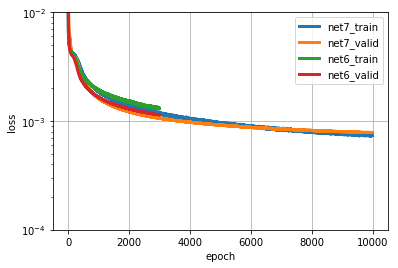

In [55]:
# Load from pickle file after first run
net6_pickle_file = "/home/sdorairaj/dev/W207Spring2017_FacialKeyPointsDetection_Misc/net6.pickle"
net7_pickle_file = "/home/sdorairaj/dev/W207Spring2017_FacialKeyPointsDetection_Misc/net7_10000epochs.pickle"

net6 = pickle.load(open(net6_pickle_file,'rb'))
net7 = pickle.load(open(net7_pickle_file,'rb'))

# plot
net7_train_loss = np.array([i["train_loss"] for i in net7.train_history_])
net7_valid_loss = np.array([i["valid_loss"] for i in net7.train_history_])
net6_train_loss = np.array([i["train_loss"] for i in net6.train_history_])
net6_valid_loss = np.array([i["valid_loss"] for i in net6.train_history_])

print net7_valid_loss
print net7_valid_loss.shape

pyplot.plot(net7_train_loss, linewidth=3, label="net7_train")
pyplot.plot(net7_valid_loss, linewidth=3, label="net7_valid")
pyplot.plot(net6_train_loss, linewidth=3, label="net6_train")
pyplot.plot(net6_valid_loss, linewidth=3, label="net6_valid")

pyplot.grid()
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.ylim(1e-4, 1e-2)
pyplot.yscale("log")

pyplot.show()

Even with 10,000 epoch here, there still do not seem to be signs of overfitting. This is most likely due the result of the drop-out layer. And the val_loss drop quite a bit to 0.00087 which translate to an RMSE score of 1.9. The validation loss seems to bottom after 10000 epochs so we will try other methods to improve the model instead of further increases in the epoch size.

## 7. Train Keypoints Separately in Groups 

Several columns in the training dataset contained NA values. When we loaded the training set to model net7, we dropped any rows that had at least one NA column. This elimination resulted in a loss of nearly 5000 rows in the 7000+ training samples. 

In this section, we will attempt improvements to our model by including as many of the columns that do not have NA values as we can. We will create specialist models. Each specialist model will focus on trying to predict a subset of the facial keypoints. This way we can split the training set to ensure that we are maximizing usage of training samples.

Here, we split keypoints into 2 groups since we notice that once set of columns have 7000+ count whereas another set has 2000+ count. 

Another optimization that we apply here is to initialize our weights with that of an existing saved neural network model, that of net7. This will allow our model to converge much faster. Note that in doing this, the weights for the output layer will not be loaded due to differing dimensions, although all other weights will be loaded.

The distribution of values in training data is shown below

* left_eye_center_x            7039
* left_eye_center_y            7039
* right_eye_center_x           7036
* right_eye_center_y           7036
* left_eye_inner_corner_x      2271
* left_eye_inner_corner_y      2271
* left_eye_outer_corner_x      2267
* left_eye_outer_corner_y      2267
* right_eye_inner_corner_x     2268
* right_eye_inner_corner_y     2268
* right_eye_outer_corner_x     2268
* right_eye_outer_corner_y     2268
* left_eyebrow_inner_end_x     2270
* left_eyebrow_inner_end_y     2270
* left_eyebrow_outer_end_x     2225
* left_eyebrow_outer_end_y     2225
* right_eyebrow_inner_end_x    2270
* right_eyebrow_inner_end_y    2270
* right_eyebrow_outer_end_x    2236
* right_eyebrow_outer_end_y    2236
* nose_tip_x                   7049
* nose_tip_y                   7049
* mouth_left_corner_x          2269
* mouth_left_corner_y          2269
* mouth_right_corner_x         2270
* mouth_right_corner_y         2270
* mouth_center_top_lip_x       2275
* mouth_center_top_lip_y       2275
* mouth_center_bottom_lip_x    7016
* mouth_center_bottom_lip_y    7016

The method fit_specialists takes as a parameter the pre-training data for initializing weights. It then fits multiple models based on the configuration of specialists settings (SPECIALIST_SETTINGS_NEW). Once the models are fitted, they are persisted in a pickle file.

In [56]:
## Group keypoints into specialists based on the data completeness
SPECIALIST_SETTINGS_NEW = [
    dict(
        columns=(
                'left_eye_center_x','left_eye_center_y',
                'right_eye_center_x','right_eye_center_y',
                'nose_tip_x','nose_tip_y',
                'mouth_center_bottom_lip_x','mouth_center_bottom_lip_y',
            ),
        flip_indices=((0, 2), (1, 3)),
        ),

    dict(
        columns=(
                'left_eye_inner_corner_x','left_eye_inner_corner_y',
                'right_eye_inner_corner_x','right_eye_inner_corner_y',
                'left_eye_outer_corner_x','left_eye_outer_corner_y',
                'right_eye_outer_corner_x','right_eye_outer_corner_y',
                'left_eyebrow_inner_end_x','left_eyebrow_inner_end_y',
                'right_eyebrow_inner_end_x','right_eyebrow_inner_end_y',
                'left_eyebrow_outer_end_x','left_eyebrow_outer_end_y',
                'right_eyebrow_outer_end_x','right_eyebrow_outer_end_y',
                'mouth_left_corner_x','mouth_left_corner_y',
                'mouth_right_corner_x','mouth_right_corner_y',
                'mouth_center_top_lip_x','mouth_center_top_lip_y',
            ),
        flip_indices=((0, 2), (1, 3), (4, 6), (5, 7),(6,8),(7,9),(8,10),(9,11),(12,14),(13,15),(16,18),(17,19)),
        ),
    ]

In [62]:
## Modify the fit function to take each specialist one at a time and combine result at the end 
from collections import OrderedDict

def fit_specialists(fname_pretrain=None):
    if fname_pretrain:  
        with open(fname_pretrain, 'rb') as f:  
            net_pretrain = pickle.load(f)  
    else:  
        net_pretrain = None 

    specialists = OrderedDict()

    for setting in SPECIALIST_SETTINGS_NEW:
        cols = setting['columns']
        X, y = load2d(cols=cols)

        model = clone(net8)
        model.output_num_units = y.shape[1]
        model.batch_iterator_train.flip_indices = setting['flip_indices']
        model.max_epochs = int(1e7 / y.shape[0])
        if 'kwargs' in setting:
            # an option 'kwargs' in the settings list may be used to
            # set any other parameter of the net:
            vars(model).update(setting['kwargs'])

        if net_pretrain is not None:  
            # if a pretrain model was given, use it to initialize the
            # weights of our new specialist model:
            model.load_params_from(net_pretrain)  

        print("Training model for columns {} for {} epochs".format(
            cols, model.max_epochs))
        model.fit(X, y)
        specialists[cols] = model

    with open('net-specialists_no_early_stopping.pickle', 'wb') as f:
        # this time we're persisting a dictionary with all models:
        pickle.dump(specialists, f, -1)
    return specialists

In [ ]:
## Load net7.pickle trained above as pretrain to reduce epoch needed for early stop
import theano

from collections import OrderedDict
from sklearn.base import clone

net8 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),  
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),  
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('dropout3', layers.DropoutLayer),  
        ('hidden4', layers.DenseLayer),
        ('dropout4', layers.DropoutLayer),  
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    dropout1_p=0.1,  
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    dropout2_p=0.2,  
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    dropout3_p=0.3,  
    hidden4_num_units=1000,
    dropout4_p=0.5,  
    hidden5_num_units=1000,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    regression=True,
    batch_iterator_train=FlipBatchIterator(batch_size=128),
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        #EarlyStopping(patience=200),
        ],
    max_epochs=5000,
    verbose=1,
    )

sys.setrecursionlimit(10000)

fname_pretrain = "/home/sdorairaj/dev/W207Spring2017_FacialKeyPointsDetection_Misc/net7_10000epochs.pickle"
fit_specialists(fname_pretrain)

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
nose_tip_x                   7049
nose_tip_y                   7049
mouth_center_bottom_lip_x    7016
mouth_center_bottom_lip_y    7016
Image                        7049
dtype: int64
left_eye_center_x            7000
left_eye_center_y            7000
right_eye_center_x           7000
right_eye_center_y           7000
nose_tip_x                   7000
nose_tip_y                   7000
mouth_center_bottom_lip_x    7000
mouth_center_bottom_lip_y    7000
Image                        7000
dtype: int64
Loaded parameters to layer 'conv1' (shape 32x1x3x3).
Loaded parameters to layer 'conv1' (shape 32).
Loaded parameters to layer 'conv2' (shape 64x32x2x2).
Loaded parameters to layer 'conv2' (shape 64).
Loaded parameters to layer 'conv3' (shape 128x64x2x2).
Loaded parameters to layer 'conv3' (shape 128).
Loaded parameters to layer 'hidden4' (shape 15488x1000).
L

     44     0.00350     0.00288    1.21425  2.99s
     44     0.00350     0.00288    1.21425  2.99s
     45     0.00345     0.00287    1.20497  3.00s
     45     0.00345     0.00287    1.20497  3.00s
     46     0.00344     0.00284    1.21232  3.01s
     46     0.00344     0.00284    1.21232  3.01s
     47     0.00345     0.00287    1.20379  3.00s
     47     0.00345     0.00287    1.20379  3.00s
     48     0.00343     0.00283    1.21325  3.01s
     48     0.00343     0.00283    1.21325  3.01s
     49     0.00340     0.00281    1.20818  3.01s
     49     0.00340     0.00281    1.20818  3.01s
     50     0.00339     0.00283    1.19998  3.01s
     50     0.00339     0.00283    1.19998  3.01s
     51     0.00341     0.00280    1.21727  3.01s
     51     0.00341     0.00280    1.21727  3.01s
     52     0.00334     0.00280    1.19438  3.04s
     52     0.00334     0.00280    1.19438  3.04s
     53     0.00337     0.00279    1.20737  3.02s
     53     0.00337     0.00279    1.20737  3.02s


    114     0.00300     0.00249    1.20130  3.01s
    114     0.00300     0.00249    1.20130  3.01s
    115     0.00298     0.00245    1.21379  3.02s
    115     0.00298     0.00245    1.21379  3.02s
    116     0.00302     0.00248    1.22194  3.02s
    116     0.00302     0.00248    1.22194  3.02s
    117     0.00297     0.00246    1.20885  3.02s
    117     0.00297     0.00246    1.20885  3.02s
    118     0.00296     0.00250    1.18584  3.02s
    118     0.00296     0.00250    1.18584  3.02s
    119     0.00294     0.00244    1.20547  3.02s
    119     0.00294     0.00244    1.20547  3.02s
    120     0.00301     0.00246    1.22348  3.02s
    120     0.00301     0.00246    1.22348  3.02s
    121     0.00294     0.00248    1.18751  3.03s
    121     0.00294     0.00248    1.18751  3.03s
    122     0.00292     0.00244    1.19664  3.02s
    122     0.00292     0.00244    1.19664  3.02s
    123     0.00296     0.00242    1.22256  3.02s
    123     0.00296     0.00242    1.22256  3.02s


#### RMSE Score for Specialists


In [39]:
# open specialists pickle
specialist_pickle_file ="/home/sdorairaj/dev/W207Spring2017_FacialKeyPointsDetection_Backup/Improvement/net-specialists_3_no_early_stopping.pickle"
specialists = pickle.load(f)

X = load2d(test=True)[0]
y_pred = np.empty((X.shape[0], 0))

count=0
for model in specialists.values():
    net8_train_loss = np.array([i["train_loss"] for i in model.train_history_])
    net8_valid_loss = np.array([i["valid_loss"] for i in model.train_history_])
    
    print "\nSpecialist:",count
    print "Training Loss:",net8_train_loss[-1]
    print "Validation Loss:",net8_valid_loss[-1]
    
    count+=1
    

ImageId    1783
Image      1783
dtype: int64
ImageId    1783
Image      1783
dtype: int64

Specialist: 0
Training Loss: 1428 0.00173984912224
Validation Loss: 1428 0.00204543352061

Specialist: 1
Training Loss: 4640 0.00843605317452
Validation Loss: 4640 0.00821091711258


In [40]:
# RMSE score o
print "RMSE score for first specialist:"
validation_loss = 0.00204543

print np.sqrt(validation_loss)*48 # normalize to [-1,1]

print "RMSE score for second specialist:"
validation_loss = 0.00821092

print np.sqrt(validation_loss)*48 # normalize to [-1,1]

RMSE score for first specialist:
2.17086865563
RMSE score for second specialist:
4.34947809283


Contrary to what we had hoped, the specialists did not yield the desired improvements and the model was only marginally better than the net7 model. Submitting the specialists to Kaggle resulted in a Kaggle Score of 3.45 which is less than the score of net7 which was 3.45.

It is unclear why this is the case. Perhaps the additional training data caused the model to overfit and therefore fail to generalize sufficiently to improve accuracy on the test set.

####Generating submission file for specialists

In [41]:
submit_aggregated_models(specialist_pickle_file)

ImageId    1783
Image      1783
dtype: int64
ImageId    1783
Image      1783
dtype: int64
Wrote submission-2017-04-23T12-33-01.542840.csv


## 8. Train a deeper net

Based on the research VGG (Visual Geometry Group) in Oxford, making the convolution net deeper could help the accuracty with image recognition (http://www.robots.ox.ac.uk/~vgg/research/very_deep/). We add an additional convolution layer to each round of convolution/pool/dropout and add an additional hidden layer with the same units as others while keep other settings the same. The idea behind this is that 2 convolution layer will recognize more surrounding pixels than 1 layer that if the previous net only recognize an eyeball, this might be able to see an eye all together. 

In retrospect, an additional hidden layer might not be necessary since it increases both training time and memory needed with minimal performance improvements.

In [ ]:
## Marked all added code with "##"
net9 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1_1', layers.Conv2DLayer),
        ('conv1_2', layers.Conv2DLayer), ##
        ('pool1', layers.MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),  
        ('conv2_1', layers.Conv2DLayer),
        ('conv2_2', layers.Conv2DLayer), ##
        ('pool2', layers.MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),  
        ('conv3_1', layers.Conv2DLayer),
        ('conv3_2', layers.Conv2DLayer), ##
        ('pool3', layers.MaxPool2DLayer),
        ('dropout3', layers.DropoutLayer),  
        ('hidden4', layers.DenseLayer),
        ('dropout4', layers.DropoutLayer),  
        ('hidden5', layers.DenseLayer),
        ('dropout5', layers.DropoutLayer), ## 
        ('hidden6', layers.DenseLayer), ##
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_1_num_filters=32, conv1_1_filter_size=(3, 3), conv1_1_pad=1,
    conv1_2_num_filters=32, conv1_2_filter_size=(3, 3), conv1_2_pad=1,
    pool1_pool_size=(2, 2),
    dropout1_p=0.1,  
    conv2_1_num_filters=64, conv2_1_filter_size=(3, 3), conv2_1_pad=1,
    conv2_2_num_filters=64, conv2_2_filter_size=(3, 3), conv2_2_pad=1,
    pool2_pool_size=(2, 2),
    dropout2_p=0.2,  
    conv3_1_num_filters=128, conv3_1_filter_size=(3, 3), conv3_1_pad=1,
    conv3_2_num_filters=128, conv3_2_filter_size=(3, 3), conv3_2_pad=1,
    pool3_pool_size=(2, 2),
    dropout3_p=0.3,  
    hidden4_num_units=1000,
    dropout4_p=0.5,  
    hidden5_num_units=1000,
    dropout5_p=0.5,  
    hidden6_num_units=1000,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    regression=True,
    batch_iterator_train=FlipBatchIterator(batch_size=128),
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        ],
    max_epochs=10000,
    verbose=1,
    )

sys.setrecursionlimit(10000)

X, y = load2d()
net9.fit(X, y)

with open('net9.pickle', 'wb') as f:
    pickle.dump(net9, f, -1)


### Evaluating net7 performance with net9

In the below section we compare the validation loss from net7 and net9 to examine further scope for improvement.

In [6]:
# Load from pickle file after first run
net9 = pickle.load(open('net9.pickle','rb'))
net7 = pickle.load(open('net7.pickle','rb'))

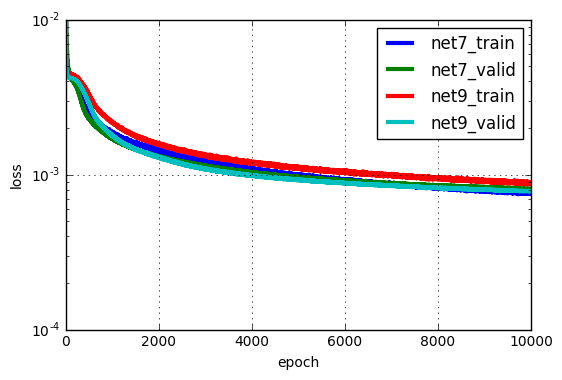

In [7]:
# plot
net9_train_loss = np.array([i["train_loss"] for i in net9.train_history_])
net9_valid_loss = np.array([i["valid_loss"] for i in net9.train_history_])
net7_train_loss = np.array([i["train_loss"] for i in net7.train_history_])
net7_valid_loss = np.array([i["valid_loss"] for i in net7.train_history_])
pyplot.plot(net7_train_loss, linewidth=3, label="net7_train")
pyplot.plot(net7_valid_loss, linewidth=3, label="net7_valid")
pyplot.plot(net9_train_loss, linewidth=3, label="net9_train")
pyplot.plot(net9_valid_loss, linewidth=3, label="net9_valid")
pyplot.grid()
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.ylim(1e-4, 1e-2)
pyplot.yscale("log")
pyplot.show()

#### RMSE Score 

In [9]:
# calculate RMSE score for this model
np.sqrt(0.00078)*48 # normalize to [-1,1]

1.3405670442018183

Making the net deeper does decrease the val_loss, however according to the plot above, it is only a marginal improvement from net7. It now get us to a val_loss of 0.00078 which translate to an RMSE score of 1.34057

## 9. An Even Deeper Net?

A deeper net in section 4 seems to work. What if make it even deeper? We then added 1 more convolution layer to each convolution/pooling/dropout layer, and also change the epoch back to 3000 to save runtime. The result will be evaluated against the val_loss of previous model at epoch 3000.

In [ ]:
## Changes are marked as "##" below
net10 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1_1', layers.Conv2DLayer),
        ('conv1_2', layers.Conv2DLayer),
        ('conv1_3', layers.Conv2DLayer), ##
        ('pool1', layers.MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),  
        ('conv2_1', layers.Conv2DLayer),
        ('conv2_2', layers.Conv2DLayer),
        ('conv2_3', layers.Conv2DLayer), ##
        ('pool2', layers.MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),  
        ('conv3_1', layers.Conv2DLayer),
        ('conv3_2', layers.Conv2DLayer),
        ('conv3_3', layers.Conv2DLayer), ##
        ('pool3', layers.MaxPool2DLayer),
        ('dropout3', layers.DropoutLayer),  
        ('hidden4', layers.DenseLayer),
        ('dropout4', layers.DropoutLayer),  
        ('hidden5', layers.DenseLayer),
        ('dropout5', layers.DropoutLayer),  
        ('hidden6', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_1_num_filters=32, conv1_1_filter_size=(3, 3), conv1_1_pad=1,
    conv1_2_num_filters=32, conv1_2_filter_size=(3, 3), conv1_2_pad=1,
    conv1_3_num_filters=32, conv1_3_filter_size=(3, 3), conv1_3_pad=1, ##
    pool1_pool_size=(2, 2),
    dropout1_p=0.1,  
    conv2_1_num_filters=64, conv2_1_filter_size=(3, 3), conv2_1_pad=1,
    conv2_2_num_filters=64, conv2_2_filter_size=(3, 3), conv2_2_pad=1,
    conv2_3_num_filters=64, conv2_3_filter_size=(3, 3), conv2_3_pad=1, ##
    pool2_pool_size=(2, 2),
    dropout2_p=0.2,  
    conv3_1_num_filters=128, conv3_1_filter_size=(3, 3), conv3_1_pad=1,
    conv3_2_num_filters=128, conv3_2_filter_size=(3, 3), conv3_2_pad=1,
    conv3_3_num_filters=128, conv3_3_filter_size=(3, 3), conv3_3_pad=1, ##
    pool3_pool_size=(2, 2),
    dropout3_p=0.3,  
    hidden4_num_units=1000,
    dropout4_p=0.5,  
    hidden5_num_units=1000,
    dropout5_p=0.5,  
    hidden6_num_units=1000,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    regression=True,
    batch_iterator_train=FlipBatchIterator(batch_size=128),
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        ],
    max_epochs=3000, ## changed it back to 3000 to save time
    verbose=1,
    )

sys.setrecursionlimit(10000)

X, y = load2d()
net10.fit(X, y)

with open('net10.pickle', 'wb') as f:
    pickle.dump(net10, f, -1)

Since I questioned whether an additional hidden layer does any help, I created net11 with only 2 hidden layer but everything else the same as net 10 just to better understand the impact of the number of hidden layers. 

In [ ]:
## Changes are marked as "##" below
import theano

net11 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1_1', layers.Conv2DLayer),
        ('conv1_2', layers.Conv2DLayer),
        ('conv1_3', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),  
        ('conv2_1', layers.Conv2DLayer),
        ('conv2_2', layers.Conv2DLayer),
        ('conv2_3', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),  
        ('conv3_1', layers.Conv2DLayer),
        ('conv3_2', layers.Conv2DLayer),
        ('conv3_3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('dropout3', layers.DropoutLayer),  
        ('hidden4', layers.DenseLayer),
        ('dropout4', layers.DropoutLayer),  
        ('hidden5', layers.DenseLayer),
       ##
       ##
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_1_num_filters=32, conv1_1_filter_size=(3, 3), conv1_1_pad=1,
    conv1_2_num_filters=32, conv1_2_filter_size=(3, 3), conv1_2_pad=1,
    conv1_3_num_filters=32, conv1_3_filter_size=(3, 3), conv1_3_pad=1,
    pool1_pool_size=(2, 2),
    dropout1_p=0.1,  
    conv2_1_num_filters=64, conv2_1_filter_size=(3, 3), conv2_1_pad=1,
    conv2_2_num_filters=64, conv2_2_filter_size=(3, 3), conv2_2_pad=1,
    conv2_3_num_filters=64, conv2_3_filter_size=(3, 3), conv2_3_pad=1,
    pool2_pool_size=(2, 2),
    dropout2_p=0.2,  
    conv3_1_num_filters=128, conv3_1_filter_size=(3, 3), conv3_1_pad=1,
    conv3_2_num_filters=128, conv3_2_filter_size=(3, 3), conv3_2_pad=1,
    conv3_3_num_filters=128, conv3_3_filter_size=(3, 3), conv3_3_pad=1,
    pool3_pool_size=(2, 2),
    dropout3_p=0.3,  
    hidden4_num_units=1000,
    dropout4_p=0.5,  
    hidden5_num_units=1000,
   ##
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    regression=True,
    batch_iterator_train=FlipBatchIterator(batch_size=128),
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        ],
    max_epochs=3000,
    verbose=1,
    )

sys.setrecursionlimit(10000)

X, y = load2d()
net11.fit(X, y)

with open('net11.pickle', 'wb') as f:
    pickle.dump(net11, f, -1)

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

/usr/lib/python2.7/site-packages/lasagne/layers/conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)


# Neural Network with 19944222 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1_1   32x96x96
  2  conv1_2   32x96x96
  3  conv1_3   32x96x96
  4  pool1     32x48x48
  5  dropout1  32x48x48
  6  conv2_1   64x48x48
  7  conv2_2   64x48x48
  8  conv2_3   64x48x48
  9  pool2     64x24x24
 10  dropout2  64x24x24
 11  conv3_1   128x24x24
 12  conv3_2   128x24x24
 13  conv3_3   128x24x24
 14  pool3     128x12x12
 15  dropout3  128x12x12
 16  hidden4   1000
 17  dropout4  1000
 18  hidden5   1000
 19  output    30

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.11286     0.01762    6.40408  4.95s
      2     0.01458     0.00711    2.05017  4.92s
      3     0.00791     0.00464    1.70506  4.93s
      4     0.00673     0.00460    1.46073  5.42s
      5     0.00641     0.00461    1.39016  5.70s
      6     0.00608     0.00453    1.34213  5.70s
      7     0.0

    131     0.00445     0.00419    1.06081  5.69s
    132     0.00444     0.00420    1.05821  5.70s
    133     0.00445     0.00419    1.06217  5.70s
    134     0.00444     0.00419    1.05968  5.69s
    135     0.00444     0.00419    1.05895  5.69s
    136     0.00443     0.00419    1.05879  5.70s
    137     0.00444     0.00419    1.05976  5.70s
    138     0.00443     0.00418    1.05917  5.70s
    139     0.00444     0.00419    1.06046  5.71s
    140     0.00444     0.00419    1.05935  5.70s
    141     0.00443     0.00419    1.05915  5.70s
    142     0.00442     0.00418    1.05683  5.70s
    143     0.00443     0.00418    1.05918  5.69s
    144     0.00443     0.00418    1.05949  5.69s
    145     0.00442     0.00418    1.05898  5.70s
    146     0.00443     0.00417    1.06239  5.70s
    147     0.00444     0.00418    1.06255  5.70s
    148     0.00443     0.00418    1.06007  5.69s
    149     0.00441     0.00417    1.05669  5.69s
    150     0.00442     0.00417    1.06014  5.69s


    269     0.00421     0.00396    1.06267  5.69s
    270     0.00420     0.00395    1.06317  5.69s
    271     0.00419     0.00395    1.06132  5.69s
    272     0.00419     0.00395    1.06058  5.69s
    273     0.00419     0.00396    1.05861  5.69s
    274     0.00419     0.00395    1.06013  5.70s
    275     0.00419     0.00394    1.06259  5.70s
    276     0.00418     0.00395    1.06024  5.69s
    277     0.00418     0.00394    1.06106  5.69s
    278     0.00417     0.00394    1.05997  5.70s
    279     0.00417     0.00394    1.05921  5.70s
    280     0.00419     0.00394    1.06329  5.69s
    281     0.00418     0.00393    1.06400  5.69s
    282     0.00418     0.00393    1.06320  5.69s
    283     0.00416     0.00394    1.05731  5.69s
    284     0.00418     0.00394    1.06178  5.69s
    285     0.00418     0.00393    1.06448  5.69s
    286     0.00417     0.00392    1.06298  5.69s
    287     0.00416     0.00392    1.06205  5.70s
    288     0.00416     0.00392    1.06170  5.70s


    409     0.00380     0.00353    1.07690  5.70s
    410     0.00380     0.00351    1.08028  5.69s
    411     0.00379     0.00352    1.07885  5.69s
    412     0.00380     0.00352    1.07916  5.69s
    413     0.00376     0.00350    1.07229  5.70s
    414     0.00378     0.00350    1.08111  5.69s
    415     0.00378     0.00350    1.07937  5.69s
    416     0.00376     0.00349    1.07706  5.70s
    417     0.00375     0.00349    1.07556  5.69s
    418     0.00374     0.00347    1.07748  5.69s
    419     0.00375     0.00347    1.08023  5.69s
    420     0.00373     0.00347    1.07492  5.69s
    421     0.00375     0.00347    1.07904  5.70s
    422     0.00374     0.00347    1.07823  5.70s
    423     0.00374     0.00346    1.08018  5.69s
    424     0.00371     0.00343    1.08106  5.71s
    425     0.00371     0.00344    1.08033  5.70s
    426     0.00371     0.00345    1.07630  5.69s
    427     0.00372     0.00343    1.08389  5.70s
    428     0.00370     0.00342    1.08012  5.69s


    540     0.00286     0.00246    1.16521  5.69s
    541     0.00284     0.00245    1.15840  5.69s
    542     0.00284     0.00244    1.16505  5.69s
    543     0.00284     0.00243    1.16826  5.69s
    544     0.00282     0.00244    1.15959  5.69s
    545     0.00282     0.00243    1.16342  5.69s
    546     0.00281     0.00241    1.16442  5.72s
    547     0.00281     0.00241    1.16571  5.69s
    548     0.00282     0.00240    1.17201  5.69s
    549     0.00281     0.00240    1.17066  5.70s
    550     0.00278     0.00239    1.16104  5.69s
    551     0.00277     0.00238    1.16529  5.71s
    552     0.00276     0.00237    1.16409  5.69s
    553     0.00280     0.00237    1.18423  5.69s
    554     0.00274     0.00236    1.16450  5.70s
    555     0.00273     0.00235    1.16169  5.69s
    556     0.00273     0.00235    1.16255  5.70s
    557     0.00274     0.00235    1.16773  5.69s
    558     0.00273     0.00234    1.16945  5.69s
    559     0.00275     0.00233    1.18200  5.69s


    678     0.00223     0.00186    1.20005  5.69s
    679     0.00222     0.00185    1.19532  5.69s
    680     0.00220     0.00186    1.18275  5.69s
    681     0.00221     0.00185    1.19346  5.69s
    682     0.00221     0.00186    1.19014  5.69s
    683     0.00222     0.00184    1.20834  5.70s
    684     0.00222     0.00185    1.20127  5.69s
    685     0.00219     0.00184    1.18973  5.69s
    686     0.00220     0.00184    1.19541  5.69s
    687     0.00217     0.00183    1.18963  5.69s
    688     0.00218     0.00183    1.19350  5.68s
    689     0.00218     0.00184    1.18404  5.69s
    690     0.00221     0.00182    1.21184  5.69s
    691     0.00220     0.00183    1.20535  5.70s
    692     0.00218     0.00182    1.19347  5.69s
    693     0.00219     0.00181    1.20633  5.70s
    694     0.00217     0.00182    1.19070  5.69s
    695     0.00216     0.00181    1.19563  5.69s
    696     0.00216     0.00182    1.18443  5.70s
    697     0.00214     0.00181    1.17915  5.69s


    822     0.00187     0.00157    1.19301  5.69s
    823     0.00188     0.00157    1.19609  5.70s
    824     0.00189     0.00157    1.20283  5.69s
    825     0.00188     0.00156    1.20266  5.69s
    826     0.00189     0.00156    1.20626  5.69s
    827     0.00189     0.00157    1.20174  5.69s
    828     0.00186     0.00155    1.19960  5.69s
    829     0.00189     0.00157    1.20566  5.69s
    830     0.00187     0.00156    1.20457  5.69s
    831     0.00187     0.00156    1.20084  5.69s
    832     0.00185     0.00155    1.18998  5.69s
    833     0.00188     0.00155    1.21014  5.69s
    834     0.00186     0.00155    1.20500  5.69s
    835     0.00186     0.00155    1.20023  5.69s
    836     0.00185     0.00155    1.19530  5.69s
    837     0.00186     0.00155    1.19844  5.69s
    838     0.00187     0.00155    1.20455  5.69s
    839     0.00183     0.00155    1.18598  5.70s
    840     0.00186     0.00154    1.20713  5.69s
    841     0.00187     0.00155    1.21079  5.69s


    970     0.00169     0.00141    1.20014  5.68s
    971     0.00166     0.00140    1.18223  5.68s
    972     0.00166     0.00140    1.18374  5.68s
    973     0.00167     0.00141    1.18362  5.68s
    974     0.00167     0.00140    1.19302  5.68s
    975     0.00164     0.00140    1.17644  5.68s
    976     0.00166     0.00140    1.18166  5.69s
    977     0.00166     0.00139    1.18905  5.69s
    978     0.00165     0.00139    1.18888  5.69s
    979     0.00166     0.00139    1.19451  5.69s
    980     0.00166     0.00139    1.19207  5.69s
    981     0.00165     0.00139    1.18981  5.68s
    982     0.00164     0.00140    1.17688  5.68s
    983     0.00166     0.00140    1.18831  5.68s
    984     0.00165     0.00139    1.18822  5.68s
    985     0.00164     0.00139    1.18363  5.68s
    986     0.00165     0.00139    1.18580  5.69s
    987     0.00166     0.00139    1.19682  5.68s
    988     0.00165     0.00139    1.18506  5.70s
    989     0.00164     0.00138    1.18298  5.69s


   1124     0.00151     0.00129    1.16886  5.69s
   1125     0.00151     0.00129    1.17099  5.68s
   1126     0.00151     0.00129    1.17346  5.68s
   1127     0.00151     0.00129    1.16594  5.68s
   1128     0.00150     0.00129    1.16280  5.69s
   1129     0.00151     0.00129    1.17381  5.68s
   1130     0.00152     0.00130    1.17412  5.69s
   1131     0.00152     0.00128    1.18324  5.69s
   1132     0.00150     0.00129    1.16842  5.69s
   1133     0.00150     0.00128    1.16581  5.69s
   1134     0.00151     0.00129    1.17647  5.69s
   1135     0.00152     0.00129    1.17966  5.69s
   1136     0.00151     0.00128    1.17840  5.69s
   1137     0.00150     0.00128    1.17117  5.68s
   1138     0.00150     0.00128    1.16927  5.69s
   1139     0.00152     0.00127    1.18993  5.68s
   1140     0.00150     0.00128    1.17116  5.69s
   1141     0.00152     0.00129    1.17764  5.68s
   1142     0.00151     0.00128    1.18607  5.68s
   1143     0.00149     0.00128    1.16066  5.69s


In [4]:
# Load from pickle file after first run
net9 = pickle.load(open('net9.pickle','rb'))
net10 = pickle.load(open('net10.pickle','rb'))
net11 = pickle.load(open('net11.pickle','rb'))

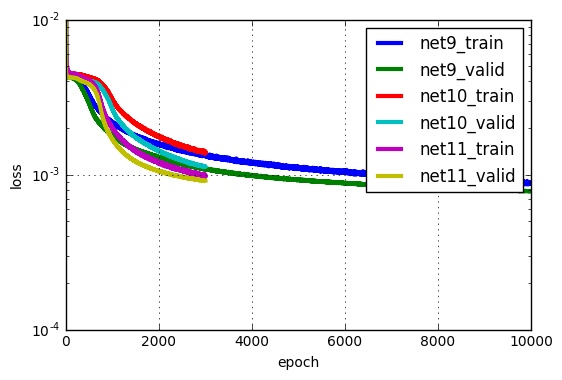

In [5]:
# plot
net9_train_loss = np.array([i["train_loss"] for i in net9.train_history_])
net9_valid_loss = np.array([i["valid_loss"] for i in net9.train_history_])
net10_train_loss = np.array([i["train_loss"] for i in net10.train_history_])
net10_valid_loss = np.array([i["valid_loss"] for i in net10.train_history_])
net11_train_loss = np.array([i["train_loss"] for i in net11.train_history_])
net11_valid_loss = np.array([i["valid_loss"] for i in net11.train_history_])
pyplot.plot(net9_train_loss, linewidth=3, label="net9_train")
pyplot.plot(net9_valid_loss, linewidth=3, label="net9_valid")
pyplot.plot(net10_train_loss, linewidth=3, label="net10_train")
pyplot.plot(net10_valid_loss, linewidth=3, label="net10_valid")
pyplot.plot(net11_train_loss, linewidth=3, label="net11_train")
pyplot.plot(net11_valid_loss, linewidth=3, label="net11_valid")
pyplot.grid()
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.ylim(1e-4, 1e-2)
pyplot.yscale("log")
pyplot.show()

From the above graph, simply adding 1 more convolution does not improve the performance compared to net9. However, reduce the hidden layer from 3 to 2 does actually help with the accuracy. One thing also interesting is that I expect having 1 less hidden layer would reduce the time to train each epoch because it require time to train 1 more layer, adjust weight, and store those addictional information. But from the result (which stores as net10.out in this directory), the time it takes for each epoch is the same for net10 and net11.

Net11 ends up with loss_val of 0.00091 at epoch 3000 compared to 0.00108 of net9 at epoch 3000. I think this indicate that net11 is highly likely to also perform better than net9 at epoch 10000, but I will not try it here consider the time and resource constraint. 